# Infineon Hackaton

Sync data with google drive

In [ ]:
#We will load the data from google drive
from google.colab import drive
drive.mount('/content/drive')
SEED = 1234

Mounted at /content/drive


In [ ]:
to_sendx = xtestfinalgg[1:50, ...]
to_sendy = ytestfinalgg[1:50, ...]

In [ ]:
import numpy as np
np.save("/content/drive/MyDrive/Challenge2/sendx", to_sendx)
np.save("/content/drive/MyDrive/Challenge2/sendy", to_sendy)

## Load and preprocess data

The data was collected during the hackaton. We created 3 different environments each with 4 classes ( number of people, 0, 1, 2, 3 ).
All the files are on drive. If you want to use the data please ask us to provide you the link

### BCL environments

In [ ]:
import pandas as pd 
import numpy as np
import pickle
import tensorflow as tf
import os 


# This file is on drive. If tou want to use it plead ask us to provide you the link
open_file = open("/content/drive/MyDrive/sample.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

array_loaded = np.array(loaded_list)
array_loaded.shape
from numpy import moveaxis
gg = moveaxis(array_loaded, 1, 3)
gg.shape

(12000, 64, 64, 3)

In [ ]:
# Deleting unused objects 
array_loaded = None
loaded_list = None 

In [ ]:
# Labels
target_2 = [0] * 3000
target_2.extend([1]*3000)
target_2.extend([2]*3000)
target_2.extend([3]*3000)
target_2 = np.array(target_2)

### Nave

Functions from infineon to preprocess the raw data

In [ ]:
from typing import Callable, Optional

import numpy as np


def range_fft(x: np.ndarray,
              window: Optional[Callable[[int], np.ndarray]] = None,
              remove_mean: bool = True) -> np.ndarray:
    """Apply a Range FFT.

    Args:
        x: Raw radar data of shape [..., n_samples].
        window: Window function for Range FFT. If None, no window is applied. Otherwise, the given window
            function is applied. (Default: None)
        remove_mean: If True, remove mean along samples dimension. (Default: True)

    Returns:
        Transformed range data of shape [..., n_range].

    Examples:
        Dummy data: 10 frames, 3 antennas, 64 chirps, 128 samples.

        >>> raw_data = np.random.rand(10,3,64,128)
        >>> range_data = range_fft(raw_data)

        Use window function. (Available in `scipy https://docs.scipy.org/doc/scipy/reference/signal.windows.html`)

        >>> from scipy import signal
        >>> range_data = range_fft(raw_data, signal.windows.blackman)

        If window function uses additional parameters you can wrap it with lambda.

        >>> range_window_func = lambda x: signal.windows.chebwin(x, at=100)
        >>> range_data = range_fft(raw_data, range_window_func)

    See Also:
        :func:`doppler_fft`: Apply a Doppler FFT.
    """
    n_samples = x.shape[-1]

    if remove_mean:
        x = x - x.mean(axis=-1, keepdims=True)

    if window is not None:
        w_array = window(n_samples)
        w_array /= w_array.sum()  # Normalize window
        x = x * w_array[(x.ndim - 1) * (None,) + (slice(None),)]
    x_range = np.fft.fft(x, axis=-1)  # Range FFT
    x_range = x_range[..., :n_samples // 2]  # Real data is symmetric

    return x_range


def doppler_fft(x: np.ndarray,
                window: Optional[Callable[[int], np.ndarray]] = None) -> np.ndarray:
    """Apply a Doppler FFT.

    Args:
        x: Range data of shape [..., n_chirps, n_range].
        window: Window function for Doppler FFT. If None, no window is applied. Otherwise, the given window
            function is applied.

    Returns:
        Transformed range doppler data of shape [..., n_doppler, n_range].

    Examples:
        Dummy data: 10 frames, 3 antennas, 64 chirps, 128 range samples.

        >>> range_data = np.random.rand(10,3,64,128)
        >>> doppler_data = doppler_fft(range_data)

        Use window function. (Available in `scipy https://docs.scipy.org/doc/scipy/reference/signal.windows.html`)

        >>> from scipy import signal
        >>> doppler_data = doppler_fft(range_data, signal.windows.blackman)

        If window function uses additional parameters you can wrap it with lambda.

        >>> doppler_window_func = lambda x: signal.windows.chebwin(x, at=100)
        >>> doppler_data  = doppler_fft(range_data, doppler_window_func)

    See Also:
        :func:`range_fft`: Apply a Range FFT.
    """
    n_chirps = x.shape[-2]

    if window is not None:
        w_array = window(n_chirps)
        w_array /= w_array.sum()  # Normalize window
        x = x * w_array[(x.ndim - 2) * (None,) + (slice(None), None)]
    x_rdi = np.fft.fft(x, axis=-2)  # Doppler FFT
    x_rdi = np.fft.fftshift(x_rdi, axes=-2)  # Swap spectrum

    return x_rdi


def range_doppler_fft(x: np.ndarray,
                      range_window: Optional[Callable[[
                          int], np.ndarray]] = None,
                      doppler_window: Optional[Callable[[
                          int], np.ndarray]] = None,
                      remove_mean: bool = True) -> np.ndarray:
    """
    Generate a Range Doppler Response.

    Args:
        x: Raw radar data of shape [..., n_chirps, n_samples].
        range_window: Window function for Range FFT. If None, no window is applied. Otherwise, the given window
            function is applied. (Default: None)
        doppler_window: Window function for Doppler FFT. If None, no window is applied. Otherwise, the given window
            function is applied. (Default: None)
        remove_mean: If True, remove mean along samples dimension. (Default: True)

    Returns:
        Transformed range data of shape [..., n_doppler, n_range].

    Examples:
        Dummy data: 10 frames, 3 antennas, 64 chirps, 128 samples.

        >>> raw_data = np.random.rand(10,3,64,128)
        >>> rdi = range_doppler_fft(raw_data)

        Use window function. (Available in `scipy https://docs.scipy.org/doc/scipy/reference/signal.windows.html`)

        >>> from scipy import signal
        >>> rdi = range_doppler_fft(raw_data, signal.windows.blackman, signal.windows.blackman)

        If window function uses additional parameters you can wrap it with lambda.

        >>> range_window_func = signal.windows.blackman
        >>> doppler_window_func = lambda x: signal.windows.chebwin(x, at=100)
        >>> rdi  = range_doppler_fft(raw_data, range_window_func, doppler_window_func)

    """

    x_range = range_fft(x, range_window, remove_mean)
    x_rdi = doppler_fft(x_range, doppler_window)

    return x_rdi

def processing_rangeDopplerData(st_data, compensateMotion=False):


    range_doppler_data = range_doppler_fft(st_data)

    return range_doppler_data

import tensorflow as tf
import os 
import numpy as np

def processing_rangeDopplerData(st_data, compensateMotion=False):
    range_doppler_data = range_doppler_fft(st_data)
    return range_doppler_data


Here we are loading our data from the Nave environment

In [ ]:
data3 = np.load('/content/drive/MyDrive/Challenge2/acquisizioni_nave/nave_raw_data_c3.npy')
range_doppler_map3 = processing_rangeDopplerData(data3)
print("(frame_index, receiver_index, chirp_index, sample_index)")
 
# The shape of the radar data depends on the radar settings.
# The different dimensions of the shape are (frame_index, receiver_index, chirp_index, sample_index).
 
data2 = np.load('/content/drive/MyDrive/Challenge2/acquisizioni_nave/nave_raw_data_c2.npy')
range_doppler_map2 = processing_rangeDopplerData(data2)
print("(frame_index, receiver_index, chirp_index, sample_index)")
 
data10 = np.load("/content/drive/MyDrive/Challenge2/acquisizioni_nave/nave_raw_data_c1e0.npy")
range_doppler_map10 = processing_rangeDopplerData(data10)
print("(frame_index, receiver_index, chirp_index, sample_index)")
data11 = np.load("/content/drive/MyDrive/Challenge2/acquisizioni_nave/nave_raw_data_c1e1.npy")
range_doppler_map11 = processing_rangeDopplerData(data11)
print("(frame_index, receiver_index, chirp_index, sample_index)")
data12 = np.load("/content/drive/MyDrive/Challenge2/acquisizioni_nave/nave_raw_data_c1e2.npy")
range_doppler_map12 = processing_rangeDopplerData(data12)
print("(frame_index, receiver_index, chirp_index, sample_index)")
 
data00 = np.load("/content/drive/MyDrive/Challenge2/acquisizioni_nave/nave_raw_data_c0e0.npy")
range_doppler_map00 = processing_rangeDopplerData(data00)
print("(frame_index, receiver_index, chirp_index, sample_index)")
data01 = np.load("/content/drive/MyDrive/Challenge2/acquisizioni_nave/nave_raw_data_c0e1.npy")
range_doppler_map01 = processing_rangeDopplerData(data01)
print("(frame_index, receiver_index, chirp_index, sample_index)")
data02 = np.load("/content/drive/MyDrive/Challenge2/acquisizioni_nave/nave_raw_data_c0e2.npy")
range_doppler_map02 = processing_rangeDopplerData(data02)
print("(frame_index, receiver_index, chirp_index, sample_index)")
 
 
data_to_append = []
 
def create_2d_image(c1, c2, c3):
    return np.vstack([np.expand_dims(c1, axis=0), np.expand_dims(c2, axis=0), np.expand_dims(c3, axis=0)])
 
for i in range(data00.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map00[i, 0, ...], range_doppler_map00[i, 1, ...], range_doppler_map00[i, 2, ...]))
for i in range(data01.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map01[i, 0, ...], range_doppler_map01[i, 1, ...], range_doppler_map01[i, 2, ...]))
for i in range(data02.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map02[i, 0, ...], range_doppler_map02[i, 1, ...], range_doppler_map02[i, 2, ...]))
for i in range(data10.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map10[i, 0, ...], range_doppler_map10[i, 1, ...], range_doppler_map10[i, 2, ...]))
for i in range(data11.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map11[i, 0, ...], range_doppler_map11[i, 1, ...], range_doppler_map11[i, 2, ...]))
for i in range(data12.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map12[i, 0, ...], range_doppler_map12[i, 1, ...], range_doppler_map12[i, 2, ...]))
for i in range(data2.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map2[i, 0, ...], range_doppler_map2[i, 1, ...], range_doppler_map2[i, 2, ...]))
for i in range(data3.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map3[i, 0, ...], range_doppler_map3[i, 1, ...], range_doppler_map3[i, 2, ...]))


array_loaded = np.array(data_to_append)
array_loaded.shape
from numpy import moveaxis
ggirenave = moveaxis(array_loaded, 1, 3)
ggirenave.shape

(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)


(12000, 64, 64, 3)

In [ ]:
array_loaded = None
loaded_list = None 
data00 = None
data01 = None
data02 = None
data10 = None
data11 = None
data12 = None
data2 = None
data3 = None
range_doppler_map3=None
range_doppler_map2=None
range_doppler_map00=None
range_doppler_map01=None
range_doppler_map02=None
range_doppler_map10=None
range_doppler_map11=None
range_doppler_map12=None
data_to_append=None

### ED 16

In [ ]:
data3 = np.load("/content/drive/MyDrive/Challenge2/ed16/ed16_raw_data_c3.npy")
range_doppler_map3 = processing_rangeDopplerData(data3)
print("(frame_index, receiver_index, chirp_index, sample_index)")
 
# The shape of the radar data depends on the radar settings.
# The different dimensions of the shape are (frame_index, receiver_index, chirp_index, sample_index).
 
data2 = np.load("/content/drive/MyDrive/Challenge2/ed16/ed16_raw_data_c2.npy")
range_doppler_map2 = processing_rangeDopplerData(data2)
print("(frame_index, receiver_index, chirp_index, sample_index)")
 
data1 = np.load("/content/drive/MyDrive/Challenge2/ed16/ed16_raw_data_c1.npy")
range_doppler_map1 = processing_rangeDopplerData(data1)
print("(frame_index, receiver_index, chirp_index, sample_index)")
 
data0 = np.load("/content/drive/MyDrive/Challenge2/ed16/ed16_raw_data_c0.npy")
range_doppler_map0 = processing_rangeDopplerData(data0)
print("(frame_index, receiver_index, chirp_index, sample_index)")
 
 
data_to_append = []
 
def create_2d_image(c1, c2, c3):
    return np.vstack([np.expand_dims(c1, axis=0), np.expand_dims(c2, axis=0), np.expand_dims(c3, axis=0)])
 
for i in range(data0.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map0[i, 0, ...], range_doppler_map0[i, 1, ...], range_doppler_map0[i, 2, ...]))
 
for i in range(data1.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map1[i, 0, ...], range_doppler_map1[i, 1, ...], range_doppler_map1[i, 2, ...]))
 
for i in range(data2.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map2[i, 0, ...], range_doppler_map2[i, 1, ...], range_doppler_map2[i, 2, ...]))
 
for i in range(data3.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map3[i, 0, ...], range_doppler_map3[i, 1, ...], range_doppler_map3[i, 2, ...]))


array_loaded = np.array(data_to_append)
array_loaded.shape
from numpy import moveaxis
gged16 = moveaxis(array_loaded, 1, 3)
gged16.shape

(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)
(frame_index, receiver_index, chirp_index, sample_index)


(12000, 64, 64, 3)

In [ ]:
array_loaded = None
data0 = None
data1 = None
data2 = None
data3 = None
range_doppler_map3=None
range_doppler_map2=None
range_doppler_map0=None
range_doppler_map1=None
data_to_append=None

## Model Building 

We use a CNN to classify each frame from the data gathered from the infineon sensor. The inputs are the frames read by the 3 antennas of our sensor. We create an RGB image by using for each antenna the respective frame. The final dimension of our input is (64, 64, 3). Where 3 is the number of channels

We use transfer learning by using a pretrained network (EfficienNetV2L) and we train the layers starting from the 700th position. We got a total number of parameters of 64 M parameters

In [ ]:
xception = tf.keras.applications.EfficientNetV2L(include_top=False,
                                            weights='imagenet',
                                            input_shape=(64, 64, 3))

xception.trainable = True



for i in range(700):
  xception.layers[i].trainable = False

model = tf.keras.Sequential()
model.add(xception)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
model.summary()

In [ ]:
# Optimization params
# -------------------
# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy()
# learning rate
lr = 3e-3     
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------
# Validation metrics
# ------------------
metrics = ["accuracy"]
# ------------------
# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Dataset

We concatenate all the data from the 3 different environments to have a unique dataset. This will surely improve the generalization in other types of environments. Only indoor since the owners told us the only indoor environments is our target

In [ ]:
from sklearn.model_selection import train_test_split
xtraingg, xtestgg, ytraingg, ytestgg = train_test_split(gg, target_2, test_size=0.2, stratify=target_2, random_state=0)
xtrainggire, xtestggire, ytrainggire, ytestggire = train_test_split(ggirenave, target_2, test_size=0.2, stratify=target_2, random_state=0)
xtraingged16, xtestgged16, ytraingged16, ytestgged16 = train_test_split(gged16, target_2, test_size=0.2, stratify=target_2, random_state=0)

In [ ]:
gg = None
ggirenave = None 
gged16 = None

In [ ]:
xtrainfinalgg = np.concatenate((xtraingg,xtrainggire,xtraingged16))
xtestfinalgg=np.concatenate((xtestgg,xtestggire,xtestgged16))
ytrainfinalgg = np.concatenate((ytraingg,ytrainggire,ytraingged16))
ytestfinalgg=np.concatenate((ytestgg,ytestggire,ytestgged16))

In [ ]:
xtrainggire=None
xtestggire=None 
ytrainggire=None 
ytestggire=None
xtraingg=None
xtestgg=None 
ytraingg=None 
ytestgg=None
xtraingged16=None
xtestgged16=None 
ytraingged16=None 
ytestgged16=None

In [ ]:
import tensorflow as tf
callbacks = []
ckpt_dir = '/content/drive/MyDrive/Challenge2'

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt)'), 
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   mode='max') # False to save the model directly) # False to save the model directly
callbacks.append(ckpt_callback)

#es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8)  #The first run was with val loss

#callbacks.append(es_callback)


## Training

In [ ]:
model.fit(x=xtrainfinalgg,  y=ytrainfinalgg,             ##Quello sotto rappresenta l'allenamento finale 
          epochs=100,  #### set repeat in traitning dataset
          validation_data=(xtestfinalgg, ytestfinalgg))

Epoch 1/100
900/900 [==============================] - 175s 158ms/step - loss: 0.6178 - accuracy: 0.7275 - val_loss: 0.8702 - val_accuracy: 0.6601
Epoch 2/100
900/900 [==============================] - 139s 155ms/step - loss: 0.4231 - accuracy: 0.8206 - val_loss: 0.4647 - val_accuracy: 0.8168
Epoch 3/100
900/900 [==============================] - 140s 155ms/step - loss: 0.3536 - accuracy: 0.8509 - val_loss: 0.3602 - val_accuracy: 0.8465
Epoch 4/100
900/900 [==============================] - 139s 154ms/step - loss: 0.3256 - accuracy: 0.8689 - val_loss: 0.4444 - val_accuracy: 0.8254
Epoch 5/100
900/900 [==============================] - 139s 154ms/step - loss: 0.2883 - accuracy: 0.8848 - val_loss: 0.3028 - val_accuracy: 0.8783
Epoch 6/100
900/900 [==============================] - 139s 154ms/step - loss: 0.2645 - accuracy: 0.8928 - val_loss: 0.2931 - val_accuracy: 0.8786
Epoch 7/100
900/900 [==============================] - 139s 154ms/step - loss: 0.2553 - accuracy: 0.8988 - val_loss: 0

KeyboardInterrupt: ignored

## Save model

In [ ]:
model.save_weights("/content/drive/MyDrive/Challenge2/checkpoint")

## Evaluate model

In [ ]:
data_new = np.load("/content/drive/MyDrive/Challenge2/ed16/ed16_raw_data_c3.npy")
range_doppler_map_new = processing_rangeDopplerData(data_new)
data_to_append_new = []
 
def create_2d_image(c1, c2, c3):
    return np.vstack([np.expand_dims(c1, axis=0), np.expand_dims(c2, axis=0), np.expand_dims(c3, axis=0)])
for i in range(data_new.shape[0]):
    data_to_append.append(create_2d_image(range_doppler_map_new[i, 0, ...], range_doppler_new[i, 1, ...], range_doppler_new[i, 2, ...]))

array_loaded_new = np.array(data_to_append_new)
array_loaded_new.shape
from numpy import moveaxis
gg_new = moveaxis(array_loaded_new, 1, 3)
gg_new.shape

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(xtestfinalgg)
predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(ytestfinalgg, predictions, normalize='true')

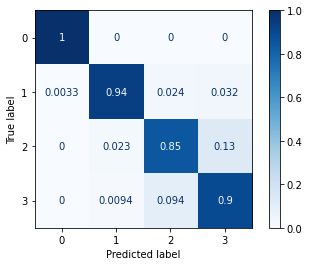

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cf = confusion_matrix(ytestfinalgg, predictions, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=["0","1","2","3"])
disp.plot(cmap=plt.cm.Greys)
